In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
import shapefile
import json

In [3]:
# =============================================================================
# Functions
# =============================================================================
def inside(lista):
    try:
        if len(lista[0])==2 and str(lista[0][0])[:3] in set(['-73', '-74']):
            return [lista]
        else:
            return 'next_level'            
    except:
        return 'next_level'

def poly_info(poly, temp, conte, sub_index=''):
    sub = '_'+str(sub_index)
    temp = temp.append(pd.DataFrame([list(item) for sublist in inside(poly) for item in sublist]))
    temp['Cod']=name+'_'+str(sub)
    temp['Bor']=boro
    geom = Polygon(zip(temp.loc[:,0],temp.loc[:,1]))
    conte.append([name+str(sub),geom])
    boroname.append(boro)

In [4]:
# =============================================================================
# Data
# =============================================================================
path = "C:\\Users\HP\Desktop\DS4A_workspace\Semana 1\Dataset\Dataset\\"
yellow = pd.read_csv(path+'\\yellow_trips_new.csv')

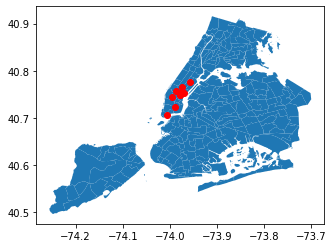

In [9]:
# =============================================================================
# NY map
# =============================================================================
path_shp = 'C:\\Users\\HP\\Documents\\GitHub\\team_32_DS4A_\\Ny'
NY_nta = shapefile.Reader(path_shp+'\\ny.shp')

conte = []
boroname = []
aux = pd.DataFrame()
for i in range(0,len(NY_nta.shapeRecords())):
    name = NY_nta.shapeRecords()[i].__geo_interface__['properties']['ntacode']
    boro = NY_nta.shapeRecords()[i].__geo_interface__['properties']['boro_name']
    coords = NY_nta.shapeRecords()[i].__geo_interface__['geometry']['coordinates']
    temp = pd.DataFrame()
    sub_1 = 0
    sub=0
    if len(coords)>1:
        for pol in coords:            
            if inside(pol)=='next_level':
                for island in pol:                    
                    if inside(island)=='next_level':
                        poly_info(island[0], temp, conte, sub)
                    else:
                        poly_info(island, temp, conte, sub)
                    sub=sub+1
            else:
                poly_info(pol, temp, conte, sub_1)                
            sub_1=sub_1+1
    else:
        if inside(coords)=='next_level':
            poly_info(coords[0],temp, conte)
        else:
            poly_info(coords, temp, conte)
    aux = aux.append(temp)

NY_poly = gpd.GeoDataFrame(columns=['Nombre','Geometria'], data=conte, geometry='Geometria')
NY_poly.plot()
plt.scatter(yellow['pickup_longitude'][:10],yellow['pickup_latitude'][:10], color='red')

In [ ]:
# =============================================================================
# Finding outside pick up points
# =============================================================================
puntos = 1000000
yellow['NTA'] = np.nan
esta_NY = [sum(NY_poly.contains(Point(yellow['pickup_longitude'][a],yellow['pickup_latitude'][a])))!=0 for a in range(0,puntos)]

fuera = yellow[['pickup_longitude','pickup_latitude']][:puntos][np.where(np.array(esta_NY)==0, True, False)]
NY_poly.plot()
plt.scatter(fuera['pickup_longitude'],fuera['pickup_latitude'], color='red')

In [ ]:
# =============================================================================
# Distance 
# =============================================================================
NY_one = list(NY_poly['Geometria'])
NY_one = cascaded_union(NY_one)
outside_points = list(fuera.index)

#Shortest distance from Point to NY polygon
distances = [Point(yellow['pickup_longitude'][a],yellow['pickup_latitude'][a]).distance(NY_one) for a in outside_points]
distances_df = pd.DataFrame(distances).rename(columns={0:'Dist'})

#Drop pickup points out of NY in the middle of the sea
sea_points = list(pd.DataFrame(outside_points)[distances_df['Dist']>=0.003][0])
yellow = yellow[0:puntos].drop(sea_points)


In [ ]:
# =============================================================================
# Classification
# =============================================================================

#Nta clasification for the outside nearest points
close_enough = list(pd.DataFrame(outside_points)[distances_df['Dist']<0.003][0])
close_nta = [int(pd.DataFrame([Point(yellow['pickup_longitude'][a],yellow['pickup_latitude'][a]).distance(nta) for nta in NY_poly['Geometria']]).idxmin()) for a in close_enough]

yellow.loc[close_enough,'NTA'] = [a[:4] for a in list(NY_poly.loc[close_nta,'Nombre'])]

#Nta clasification for the remaining
remaining = list(set(yellow.index)-set(close_enough))
yellow.loc[remaining,'NTA'] = [list(NY_poly[NY_poly.contains(Point(yellow['pickup_longitude'][a],yellow['pickup_latitude'][a]))]['Nombre'])[0][:4] for a in remaining]